## Data Loading

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS =20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'rice_leaf_disease_images',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5933 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

In [5]:
len(dataset) #186*32=5931

186

In [6]:
# One random batch of images
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 2 2 0 3 1 0 0 1 2 3 0 0 2 1 0 0 2 3 3 2 0 1 2 0 2 1 1 3 0 3]


(32, 256, 256, 3)
[2 1 2 1 3 3 1 1 3 1 3 2 3 2 1 2 0 3 2 0 0 0 1 3 2 2 0 2 0 2 2 2]


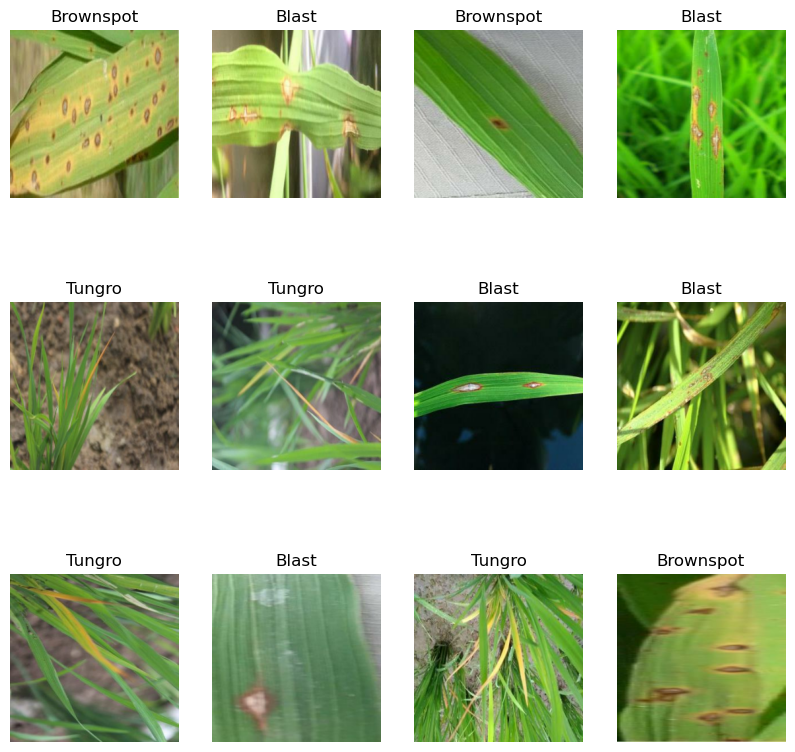

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12): #showing 12 images out of 32
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
# (32=batch_size, 256, 256=image_size, 0 to 3=typesofdiseases)
# 0 - Bacterial Blight
# 1 - Blast
# 2 - Brownspot
# 3 - Tungro

In [9]:
# Spitting dataset for training, validation and testing
# 80% for training 10% for validation and 10% for testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [1]:
# Catching and prefeching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

NameError: name 'train_ds' is not defined

## Preprocessing

In [22]:
def augment(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image = (image / 255.0)
  image = tf.image.random_crop(image, size=[BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS])
  image = tf.image.random_brightness(image, max_delta=0.5)
  return image, label

In [23]:

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [64]:
# Layer for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [65]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Convolution Neural Network

In [75]:
#input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes= 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [76]:
model.build(input_shape = input_shape)

In [77]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [78]:
model.compile(
    optimizer='rmsprop', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy'])

In [79]:
logdir='logs'

In [80]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2,
    validation_data=val_ds,
    callbacks=tensorboard_callback
)

Epoch 1/20
148/148 - 472s - loss: 1.2013 - accuracy: 0.4715 - val_loss: 1.0326 - val_accuracy: 0.5885 - 472s/epoch - 3s/step
Epoch 2/20
148/148 - 452s - loss: 0.8794 - accuracy: 0.6502 - val_loss: 0.7448 - val_accuracy: 0.7222 - 452s/epoch - 3s/step
Epoch 3/20
148/148 - 336s - loss: 0.6871 - accuracy: 0.7399 - val_loss: 0.5112 - val_accuracy: 0.7882 - 336s/epoch - 2s/step
Epoch 4/20
148/148 - 284s - loss: 0.5119 - accuracy: 0.8050 - val_loss: 1.3576 - val_accuracy: 0.5660 - 284s/epoch - 2s/step
Epoch 5/20
148/148 - 283s - loss: 0.4084 - accuracy: 0.8503 - val_loss: 0.3758 - val_accuracy: 0.8333 - 283s/epoch - 2s/step
Epoch 6/20
148/148 - 309s - loss: 0.3211 - accuracy: 0.8792 - val_loss: 0.1671 - val_accuracy: 0.9427 - 309s/epoch - 2s/step
Epoch 7/20
148/148 - 331s - loss: 0.2476 - accuracy: 0.9127 - val_loss: 0.3766 - val_accuracy: 0.8698 - 331s/epoch - 2s/step
Epoch 8/20
148/148 - 287s - loss: 0.2223 - accuracy: 0.9237 - val_loss: 0.0941 - val_accuracy: 0.9635 - 287s/epoch - 2s/step


In [ ]:
scores = model.evaluate(test_ds)
scores

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    prediction_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])),2)
    
    return prediction_class, confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'predicted: {predicted_class},\n confidence: {confidence}, \n Actual: {actual_class}')
        plt.axis("off")

In [ ]:
# Saving the model
model_version = max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f'models\{model_version}')

In [12]:
new_model = tf.keras.models.load_model('models/26')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [13]:
scores = new_model.evaluate(test_ds)
scores

20/20 [==============================] - 39s 708ms/step - loss: 8.7394e-04 - accuracy: 1.0000


[0.0008739417535252869, 1.0]

In [14]:
print("Accuracy : {:.3f}".format(scores[1]))

Accuracy : 1.000


New Image Prediction

In [15]:
import cv2
import numpy as np

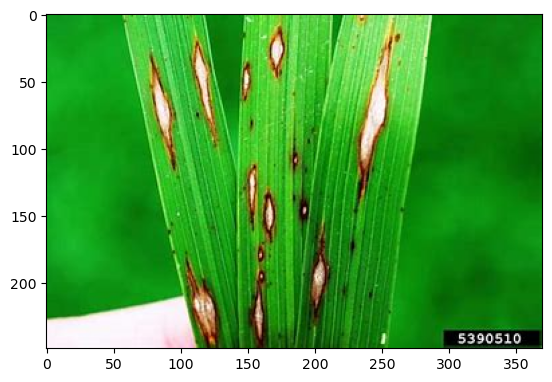

In [62]:
#img_path = cv2.imread(os.path.join('rice_leaf_disease_images','Tungro','TUNGRO1_020.jpg'))
img_path = cv2.imread(os.path.join('Testing images','blast.jpg'))
img_path = cv2.cvtColor(img_path,cv2.COLOR_BGR2RGB)
plt.imshow(img_path)

In [63]:
img = cv2.resize(img_path,(256,256))
img = np.reshape(img,[1,256,256,3])

In [64]:
pred = new_model.predict(img)

1/1 [==============================] - 0s 102ms/step


In [65]:
pred

array([[1.7181195e-03, 9.9708384e-01, 1.1980014e-03, 4.2299068e-12]],
      dtype=float32)

In [66]:
prediction_class = class_names[np.argmax(pred)]
prediction_class

'Blast'

10 Cnn without augmentation
12 CNN with 2 epochs with augmentation

In [21]:
#Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix , classification_report

20/20 [==============================] - 13s 630ms/step


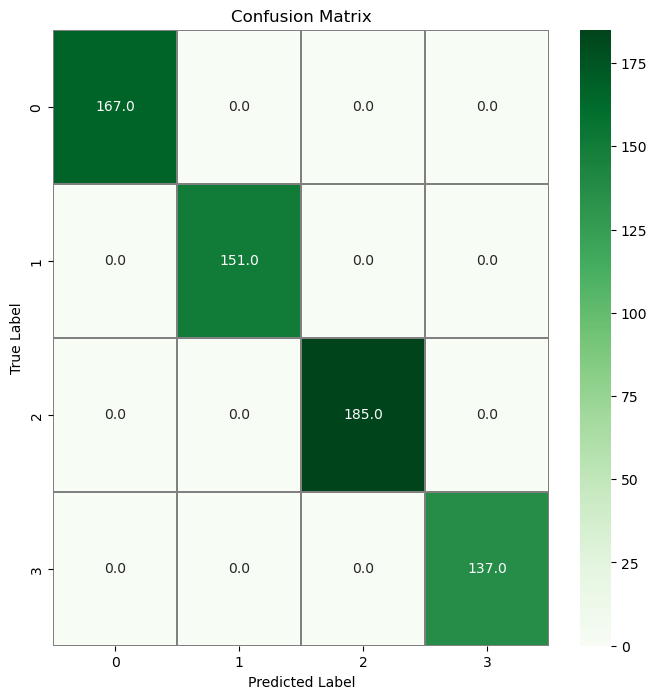

In [23]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = new_model.predict(test_ds)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = tf.concat([y for x, y in test_ds], axis=0)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

                 precision    recall  f1-score   support

Bacterialblight       1.00      1.00      1.00       167
          Blast       1.00      1.00      1.00       151
      Brownspot       1.00      1.00      1.00       185
         Tungro       1.00      1.00      1.00       137

       accuracy                           1.00       640
      macro avg       1.00      1.00      1.00       640
   weighted avg       1.00      1.00      1.00       640

